In [1]:
import json
import pandas as pd
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from joblib import Parallel, delayed
import os
import multiprocessing
import seaborn as sns
import numpy as np


In [2]:

# Carregar dados JSON
with open('./MC3/mc3.json', 'r') as f:
    data = json.load(f)

In [3]:

# Converter dados para DataFrames
df_nodos = pd.DataFrame(data['nodes'])
df_links = pd.DataFrame(data['links'])

Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

# Estrutura das organizacoes


In [241]:

# Função para converter string de data para objeto de data
def convert_to_date(date_str):
    try:
        return pd.to_datetime(date_str, format="%Y-%m-%d").date()
    except ValueError:
        return pd.to_datetime(date_str).date()
    
# Função para atualizar a coluna 'category_with_year'

# Função para atualizar a coluna 'category_with_year'
def update_category_with_year(row, grouped, marked_categories):
    
    if row['target'] in grouped['target'].values:
        if row['target'] not in marked_categories:
            marked_categories.add(row['target'])
            return f"{row['target']} ({grouped.loc[grouped['target'] == row['target'], 'year'].values[0]})"
        else:
            return f"{row['target']} ({grouped.loc[grouped['target'] == row['target'], 'year'].values[0]})"
    else:
        return 'Outros'
    


In [5]:
# Aplicar a função de conversão de data
df_links['start_date'] = df_links['start_date'].apply(convert_to_date)
df_links['_last_edited_date'] = df_links['_last_edited_date'].apply(convert_to_date)
df_links['_date_added'] = df_links['_date_added'].apply(convert_to_date)
df_links['end_date'] = df_links['end_date'].apply(convert_to_date)

In [6]:
df_links['year'] = pd.to_datetime(df_links['start_date']).dt.year
df_links['anomes'] = pd.to_datetime(df_links['start_date']).dt.to_period('M') ##

df_links = df_links[df_links['year'] > 2000]

In [7]:
# Contagem de relações por ano, tipo e target
relations_per_year_type_target = df_links[df_links['type'] != 'Relationship.FamilyRelationship']

relations_per_year_type_target = relations_per_year_type_target.groupby(['year', 'type', 'target']).size().reset_index(name='counts')

# Calcular a média das contagens por ano, tipo e target
average_relations_per_year_type_target = relations_per_year_type_target.groupby(['year', 'type'])['counts'].mean().reset_index(name='average_counts')

# Criação da visualização temporal
fig = px.bar(average_relations_per_year_type_target, x='year', y='average_counts', color='type', 
             title='Média das Mudanças nas Estruturas Corporativas ao Longo do Tempo', barmode='stack')

# Ajustar layout para exibir anos na vertical e sem ordenação automática
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)

fig.show()

In [122]:
# Função para selecionar os maiores alvos de cada ano com o respectivo ano
def get_top_target_per_year(df):
    top_targets = df.groupby('year').apply(lambda x: x.nlargest(1, 'count_events')).reset_index(drop=True)
    return top_targets

## Ownership

In [243]:
# Filtrando dados pelo tipo
data_filtered = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

# Contagem de relações por ano e cálculo da média
relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].mean().reset_index(name='counts')

# Criação da visualização temporal usando gráfico de linhas
fig = px.line(relations_per_year, x='year', y='counts', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    xaxis_title='Ano',
    yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 1}  # Garantir que todos os anos sejam exibidos
)
fig.show()

In [41]:
#media geral de beneficalowndership por ano
df_counts_beneficial_ownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_counts_beneficial_ownership = df_counts_beneficial_ownership.groupby(['year', 'type', 'target']).size().reset_index(name='count_events')

In [ ]:

# Selecionar os maiores alvos de cada ano com o respectivo ano
top_per_year = get_top_target_per_year(df_counts_beneficial_ownership)

# Agrupar por categoria principal e concatenar os anos em uma string separada por vírgula para top_per_year
grouped = top_per_year.groupby('target')['year'].apply(lambda x: ', '.join(x.astype(str).unique())).reset_index()

# Conjunto para armazenar categorias já marcadas como específicas
marked_categories = set()

# Aplicar a função para atualizar 'category_with_year' e adicionar ao DataFrame
df_counts_beneficial_ownership['category_with_year'] = df_counts_beneficial_ownership.apply(
    lambda row: update_category_with_year(row, grouped, marked_categories),
    axis=1
)

# Criar a paleta de cores usando seaborn colorblind para cada categoria única
unique_categories = df_counts_beneficial_ownership['category_with_year'].unique()
palette = sns.color_palette('colorblind', n_colors=len(unique_categories))
color_map = dict(zip(unique_categories, palette))

# Definir uma cor específica para a categoria "Outros"
color_map['Outros'] = 'lightgray'

# Criar o scatter plot com legendas diferenciadas e cores personalizadas
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    x='year', y='count_events', hue='category_with_year', data=df_counts_beneficial_ownership,
    alpha=0.7, palette=color_map
)

plt.title('Scatter Plot de Eventos de Compras por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(rotation=45)

# Criar legendas personalizadas com nome da categoria e anos correspondentes para "Top"
legend_labels = df_counts_beneficial_ownership.drop_duplicates('category_with_year')['category_with_year'].tolist()
plt.legend(title='Alvos', bbox_to_anchor=(1.05, 1), loc='upper left', labels=legend_labels)

plt.show()


In [384]:
df_maas_owndership = top_per_year[['year', 'type', 'target', 'count_events']].sort_values('count_events', ascending=False).head(5)
df_maas_owndership


,year,type,target,count_events
29,2034.0,Event.Owns.BeneficialOwnership,Downs Group,119
30,2035.0,Event.Owns.BeneficialOwnership,Polák Procházka a.s.,25
28,2033.0,Event.Owns.BeneficialOwnership,"Williams, Brown and Palmer",16
26,2031.0,Event.Owns.BeneficialOwnership,"Williams, Brown and Palmer",15
27,2032.0,Event.Owns.BeneficialOwnership,"Jones, Foster and Sanford",14


In [179]:
df_downs_group = df_links[(df_links['target'] == 'Downs Group') & (df_links['year'] == 2034)][['source', 'start_date', 'type']].sort_values('start_date')

In [180]:
df_downs_group = df_downs_group.merge(df_nodos, left_on='source', right_on='id', how='left')[['source', 'type_y']]

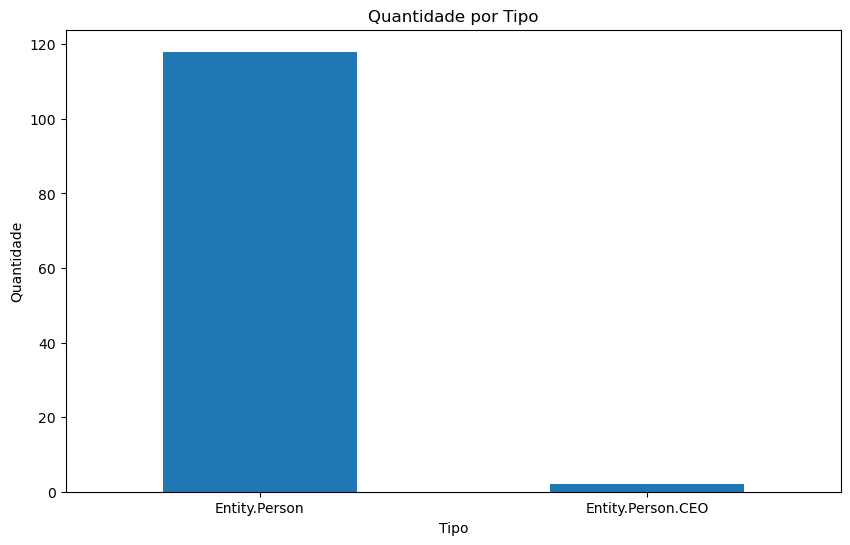

In [181]:
# Contar a quantidade por tipo
type_counts = df_downs_group['type_y'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')
plt.title('Quantidade por Tipo')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

In [182]:
df_downs_group[df_downs_group['type_y'] == 'Entity.Person.CEO']

,source,type_y
61,April Carter,Entity.Person.CEO
88,Lisa Hart,Entity.Person.CEO


## Shareholdership

In [246]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Event.Owns.Shareholdership']

relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.line(relations_per_year, x='year', y='counts', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

In [237]:
#media geral de beneficalowndership por ano
df_counts_Sharedholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_counts_Sharedholdership = df_counts_Sharedholdership[df_counts_Sharedholdership['year'] > 2005]
df_counts_Sharedholdership = df_counts_Sharedholdership.groupby(['year', 'type', 'target']).size().reset_index(name='count_events')
#df_counts_Sharedholdership.sort_values('count_events', ascending=False)

C:\Users\maico\AppData\Local\Temp\ipykernel_13852\687169895.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



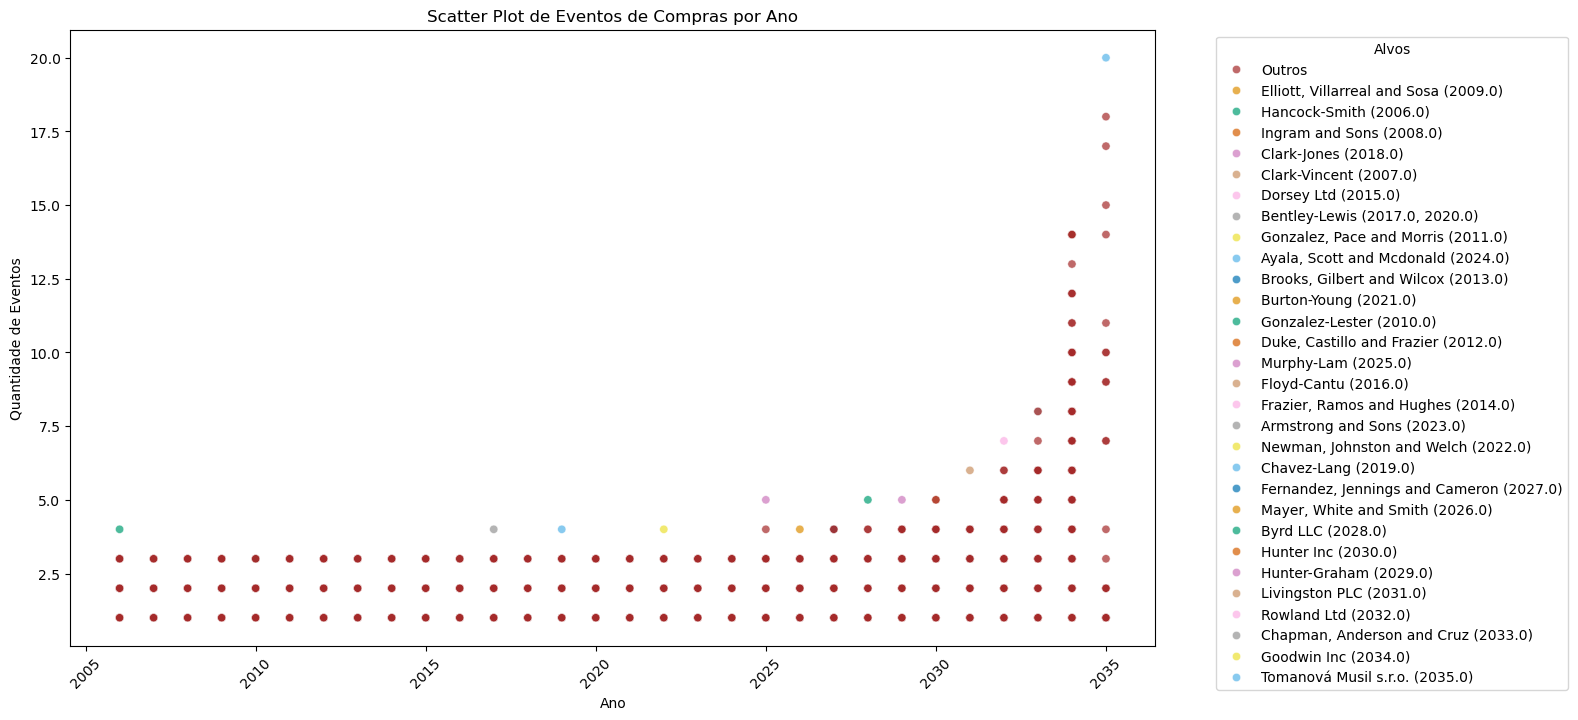

In [238]:

# Selecionar os maiores alvos de cada ano com o respectivo ano
top_per_year = get_top_target_per_year(df_counts_Sharedholdership)

# Agrupar por categoria principal e concatenar os anos em uma string separada por vírgula para top_per_year
grouped = top_per_year.groupby('target')['year'].apply(lambda x: ', '.join(x.astype(str).unique())).reset_index()

# Conjunto para armazenar categorias já marcadas como específicas
marked_categories = set()

# Aplicar a função para atualizar 'category_with_year' e adicionar ao DataFrame
df_counts_Sharedholdership['category_with_year'] = df_counts_Sharedholdership.apply(
    lambda row: update_category_with_year(row, grouped, marked_categories),
    axis=1
)

# Criar a paleta de cores usando seaborn colorblind para cada categoria única
unique_categories = df_counts_Sharedholdership['category_with_year'].unique()
palette = sns.color_palette('colorblind', n_colors=len(unique_categories))
color_map = dict(zip(unique_categories, palette))

# Definir uma cor específica para a categoria "Outros"
color_map['Outros'] = 'brown'

# Criar o scatter plot com legendas diferenciadas e cores personalizadas
plt.figure(figsize=(14, 8))
scatterplot = sns.scatterplot(
    x='year', y='count_events', hue='category_with_year', data=df_counts_Sharedholdership,
    alpha=0.7, palette=color_map
)

plt.title('Scatter Plot de Eventos de Compras por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(rotation=45)

# Criar legendas personalizadas com nome da categoria e anos correspondentes para "Top"
handles, _ = scatterplot.get_legend_handles_labels()
legend_labels = df_counts_Sharedholdership.drop_duplicates('category_with_year')['category_with_year'].tolist()
plt.legend(handles=handles, labels=legend_labels, title='Alvos', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [186]:
df_mas_Sharedholdership = top_per_year[['year', 'type', 'target', 'count_events']].sort_values('count_events', ascending=False).head(5)
df_mas_Sharedholdership


,year,type,target,count_events
34,2035.0,Event.Owns.Shareholdership,Tomanová Musil s.r.o.,20
33,2034.0,Event.Owns.Shareholdership,Goodwin Inc,14
32,2033.0,Event.Owns.Shareholdership,"Chapman, Anderson and Cruz",8
31,2032.0,Event.Owns.Shareholdership,Rowland Ltd,7
30,2031.0,Event.Owns.Shareholdership,Livingston PLC,6


In [189]:
df_Tomanova = df_links[(df_links['target'] == 'Tomanová Musil s.r.o.') & (df_links['year'] == 2035) & 
                          (df_links['type'] == 'Event.Owns.Shareholdership')][['source', 'start_date', 'type']].sort_values('start_date')
df_Tomanova

,source,start_date,type
38,"Gallegos, Brooks and Miller",2035-01-29,Event.Owns.Shareholdership
57918,Ashley Chen,2035-01-29,Event.Owns.Shareholdership
57916,Emily Mcdonald,2035-01-29,Event.Owns.Shareholdership
57913,Wesley Hill,2035-01-29,Event.Owns.Shareholdership
57910,John Weber,2035-01-29,Event.Owns.Shareholdership
57908,Joseph Moore,2035-01-29,Event.Owns.Shareholdership
50287,Deborah Juarez,2035-01-29,Event.Owns.Shareholdership
28682,Daniel Meyers,2035-01-29,Event.Owns.Shareholdership
28680,Tina Jacobson,2035-01-29,Event.Owns.Shareholdership
28678,Darlene White,2035-01-29,Event.Owns.Shareholdership


In [190]:
df_Tomanova = df_Tomanova.merge(df_nodos, left_on='source', right_on='id', how='left')[['source', 'type_y']]
df_Tomanova

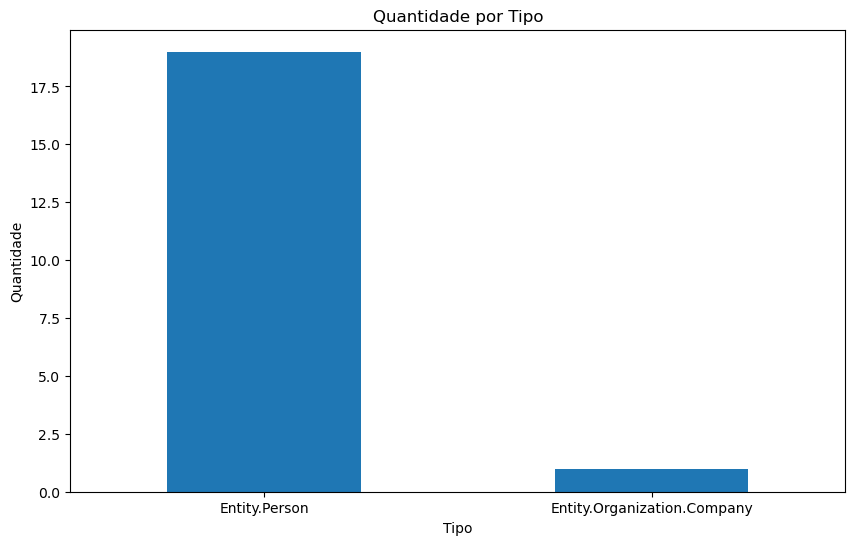

In [192]:
# Contar a quantidade por tipo
type_counts = df_Tomanova['type_y'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar')
plt.title('Quantidade por Tipo')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.xticks(rotation=0)
plt.show()

In [194]:
df_Tomanova[df_Tomanova['type_y'] == 'Entity.Organization.Company']

,source,type_y
0,"Gallegos, Brooks and Miller",Entity.Organization.Company


## Worksfor

In [247]:
# Contagem de relações por ano
data_filtered = df_links[df_links['type'] == 'Event.WorksFor']

relations_per_year = data_filtered.groupby(['year', 'type', 'target']).size().reset_index(name='counts')
relations_per_year = relations_per_year.groupby(['year', 'type'])['counts'].size().reset_index(name='counts')

# Criação da visualização temporal
fig = px.line(relations_per_year, x='year', y='counts', title='Mudanças nas Estruturas Corporativas ao Longo do Tempo')
fig.update_layout(
    #xaxis_title='Ano',
    #yaxis_title='Média de Contagens',
    xaxis_tickangle=-90,
    xaxis={'dtick': 5}#,  # Garantir que todos os anos sejam exibidos
    #xaxis={'categoryorder': 'array', 'categoryarray': average_relations_per_year_type_target['year']}
)
fig.show()

In [198]:
#media geral de beneficalowndership por ano
df_counts_WorksFor = df_links[df_links['type'] == 'Event.WorksFor']
df_counts_WorksFor = df_counts_WorksFor.groupby(['year', 'type', 'target']).size().reset_index(name='count_events')
df_counts_WorksFor.sort_values('year', inplace=True)

C:\Users\maico\AppData\Local\Temp\ipykernel_13852\687169895.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



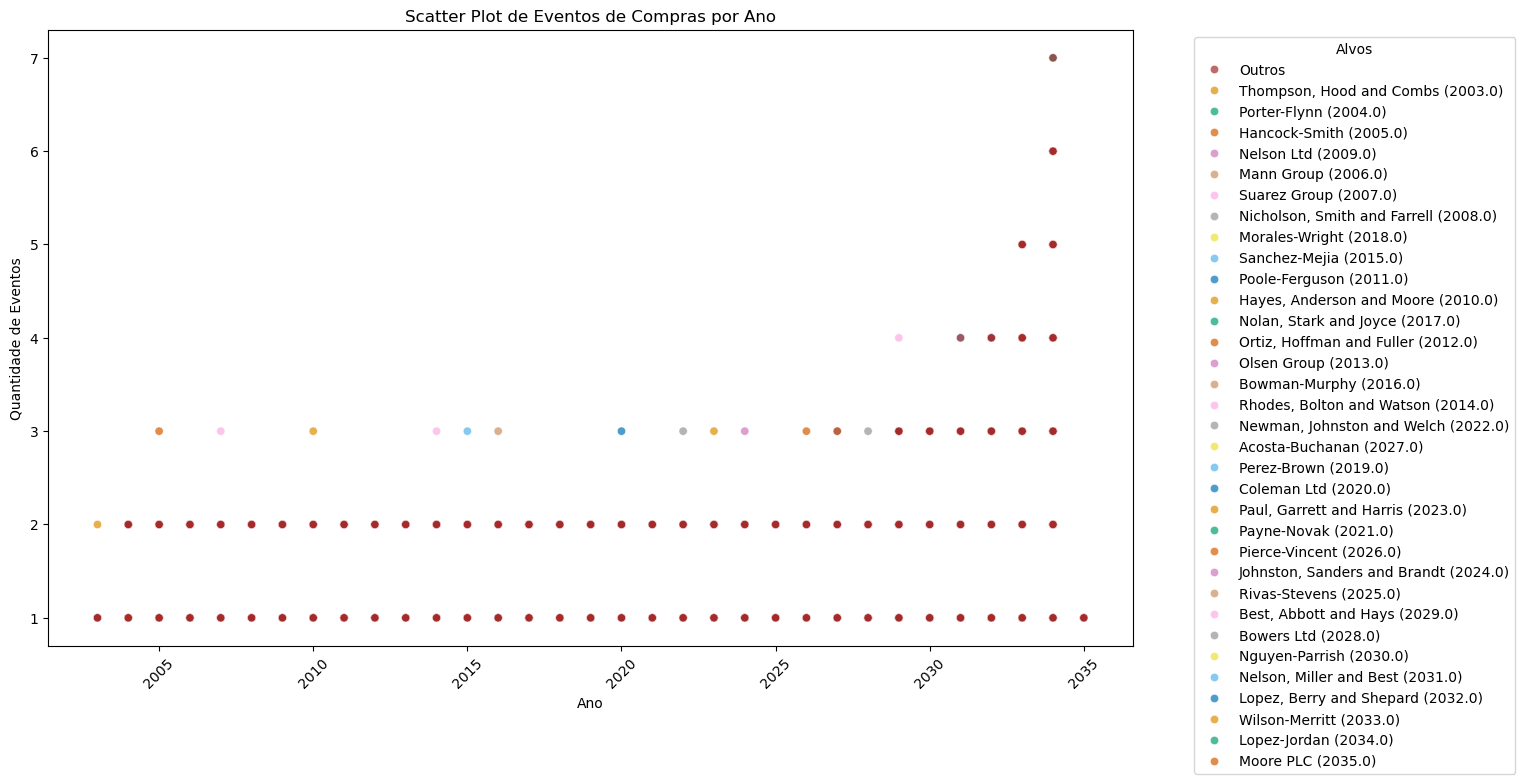

In [199]:

# Selecionar os maiores alvos de cada ano com o respectivo ano
top_per_year = get_top_target_per_year(df_counts_WorksFor)

# Agrupar por categoria principal e concatenar os anos em uma string separada por vírgula para top_per_year
grouped = top_per_year.groupby('target')['year'].apply(lambda x: ', '.join(x.astype(str).unique())).reset_index()

# Conjunto para armazenar categorias já marcadas como específicas
marked_categories = set()

# Aplicar a função para atualizar 'category_with_year' e adicionar ao DataFrame
df_counts_WorksFor['category_with_year'] = df_counts_WorksFor.apply(
    lambda row: update_category_with_year(row, grouped, marked_categories),
    axis=1
)

# Criar a paleta de cores usando seaborn colorblind para cada categoria única
unique_categories = df_counts_WorksFor['category_with_year'].unique()
palette = sns.color_palette('colorblind', n_colors=len(unique_categories))
color_map = dict(zip(unique_categories, palette))

# Definir uma cor específica para a categoria "Outros"
color_map['Outros'] = 'brown'

# Criar o scatter plot com legendas diferenciadas e cores personalizadas
plt.figure(figsize=(14, 8))
scatterplot = sns.scatterplot(
    x='year', y='count_events', hue='category_with_year', data=df_counts_WorksFor,
    alpha=0.7, palette=color_map
)

plt.title('Scatter Plot de Eventos de Compras por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Eventos')
plt.xticks(rotation=45)

# Criar legendas personalizadas com nome da categoria e anos correspondentes para "Top"
handles, _ = scatterplot.get_legend_handles_labels()
legend_labels = df_counts_WorksFor.drop_duplicates('category_with_year')['category_with_year'].tolist()
plt.legend(handles=handles, labels=legend_labels, title='Alvos', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [200]:
df_mas_works = top_per_year[['year', 'type', 'target', 'count_events']].sort_values('count_events', ascending=False).head(5)
df_mas_works


,year,type,target,count_events
31,2034.0,Event.WorksFor,Lopez-Jordan,7
30,2033.0,Event.WorksFor,Wilson-Merritt,5
26,2029.0,Event.WorksFor,"Best, Abbott and Hays",4
29,2032.0,Event.WorksFor,"Lopez, Berry and Shepard",4
28,2031.0,Event.WorksFor,"Nelson, Miller and Best",4


In [202]:
df_Lopez = df_links[(df_links['target'] == 'Lopez-Jordan') & (df_links['year'] == 2034) & 
                          (df_links['type'] == 'Event.WorksFor')][['source', 'start_date', 'type']].sort_values('start_date')
df_Lopez

,source,start_date,type
52050,Tyler Burgess,2034-03-14,Event.WorksFor
52038,Randy Ramirez,2034-04-23,Event.WorksFor
52053,Dustin Bradley,2034-04-26,Event.WorksFor
52045,Thomas Spears,2034-06-25,Event.WorksFor
52048,Christopher Barajas,2034-07-18,Event.WorksFor
52036,Benito Partida Gastélum,2034-08-08,Event.WorksFor
52042,Daniel Cobb,2034-09-03,Event.WorksFor


In [203]:
df_Lopez = df_Tomanova.merge(df_nodos, left_on='source', right_on='id', how='left')[['source', 'type_y']]
df_Lopez

,source,type_y
0,Tyler Burgess,Entity.Person
1,Randy Ramirez,Entity.Person
2,Dustin Bradley,Entity.Person
3,Thomas Spears,Entity.Person
4,Christopher Barajas,Entity.Person
5,Benito Partida Gastélum,Entity.Person
6,Daniel Cobb,Entity.Person


# refazendo primeiro item    

Os analistas da FishEye querem visualizar melhor as mudanças nas estruturas corporativas ao longo do tempo. Crie uma abordagem de análise visual que os analistas possam usar para destacar padrões temporais e mudanças nas estruturas corporativas. Examine as pessoas e empresas mais ativas usando análise visual.

Visualização Temporal das Estruturas Corporativas
Para visualizar as mudanças nas estruturas corporativas ao longo do tempo, vamos criar uma visualização interativa:

In [207]:
df_links_property = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficial = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']

## Empresas adquirentes

In [209]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_targets(df): #empresas adquirentes
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df): #empresas com adquiridas
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership_adquirentes = count_unique_targets(df_links_shareholdership)
count_beneficialownership_adquirentes = count_unique_targets(df_links_beneficialownership)
count_works = count_unique_sources(df_links_worksfor)
count_familyrelationship = count_unique_targets(df_links_familyrelationship)

In [210]:
max_shareholder_year = count_shareholdership_adquirentes.groupby('start_date')['count'].max().reset_index()
max_beneficialownership_year = count_beneficialownership_adquirentes.groupby('start_date')['count'].max().reset_index()
max_count_worksfor_year = count_works.groupby('start_date')['count'].max().reset_index()

In [211]:
df_links['start_date'] = pd.to_datetime(df_links['start_date'])

#Filtrar os tipos de relação desejados
df_links_shareholdership = df_links[df_links['type'] == 'Event.Owns.Shareholdership']
df_links_beneficialownership = df_links[df_links['type'] == 'Event.Owns.BeneficialOwnership']
df_links_worksfor = df_links[df_links['type'] == 'Event.WorksFor']
df_links_familyrelationship = df_links[df_links['type'] == 'Relationship.FamilyRelationship']

# Criar uma função para calcular a quantidade de empresas únicas por source e ano
def count_unique_source(df): #empresas adquirentes
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

def count_unique_targets(df): #empresas adquiridas
    return df.groupby(['source', df['start_date'].dt.year])['target'].nunique().reset_index(name='count')

def count_unique_sources(df): #empresas com funcionarios
    return df.groupby(['target', df['start_date'].dt.year])['source'].nunique().reset_index(name='count')

# Aplicar a função para cada tipo de relação
count_shareholdership_adquirentes = count_unique_source(df_links_shareholdership)
count_beneficialownership_adquirentes = count_unique_source(df_links_beneficialownership)

count_shareholdership_adquiridas = count_unique_targets(df_links_shareholdership)
count_beneficialownership_adquiridas = count_unique_targets(df_links_beneficialownership)


count_works = count_unique_source(df_links_worksfor)
#count_familyrelationship = count_unique_source(df_links_familyrelationship)

In [212]:
max_shareholder_year_adquirentes = count_shareholdership_adquirentes.groupby('start_date')['count'].max().reset_index()
#max_beneficialownership_year = count_beneficialownership_adquirentes.groupby('start_date')['count'].max().reset_index()
#max_count_worksfor_year = count_works.groupby('start_date')['count'].max().reset_index()

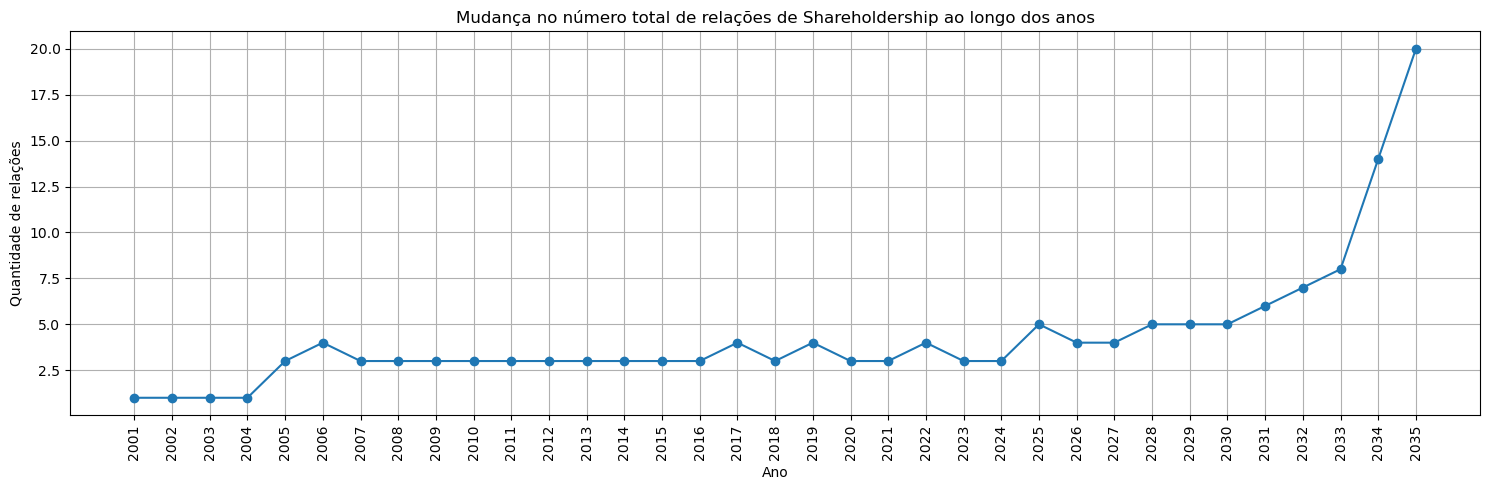

In [213]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_shareholder_year_adquirentes['start_date'], max_shareholder_year_adquirentes['count'], marker='o')
plt.title('Mudança no número total de relações de Shareholdership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_shareholder_year_adquirentes['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [214]:
media_shareholder = max_shareholder_year['count'].mean()
media_shareholder = 4

In [215]:
count_shareholdership_adquirentes[count_shareholdership_adquirentes['count'] > media_shareholder]

,target,start_date,count
297,Allen Inc,2034,7
399,"Allen, Villa and Allen",2034,5
400,Allen-Beltran,2034,8
427,Allen-Taylor,2034,5
1331,"Banks, Gray and Gonzales",2032,6
...,...,...,...
33063,"Zhang, Cunningham and Kline",2034,5
33070,"Zimmerman, Garrison and Frazier",2033,5
33071,"Zimmerman, Garrison and Frazier",2034,9
33080,Čechová Kašpar s.r.o.,2035,9


In [216]:
df = count_shareholdership_adquirentes[count_shareholdership_adquirentes['count'] > media_shareholder]
df = df.groupby(['count', 'start_date']).size().reset_index(name='num_companies').sort_values(by='start_date')
df = df.rename(columns={'count': 'count_shareholdership_adquirentes'})
#df.sort_values(by='count_shareholdership_adquirentes', ascending=False)

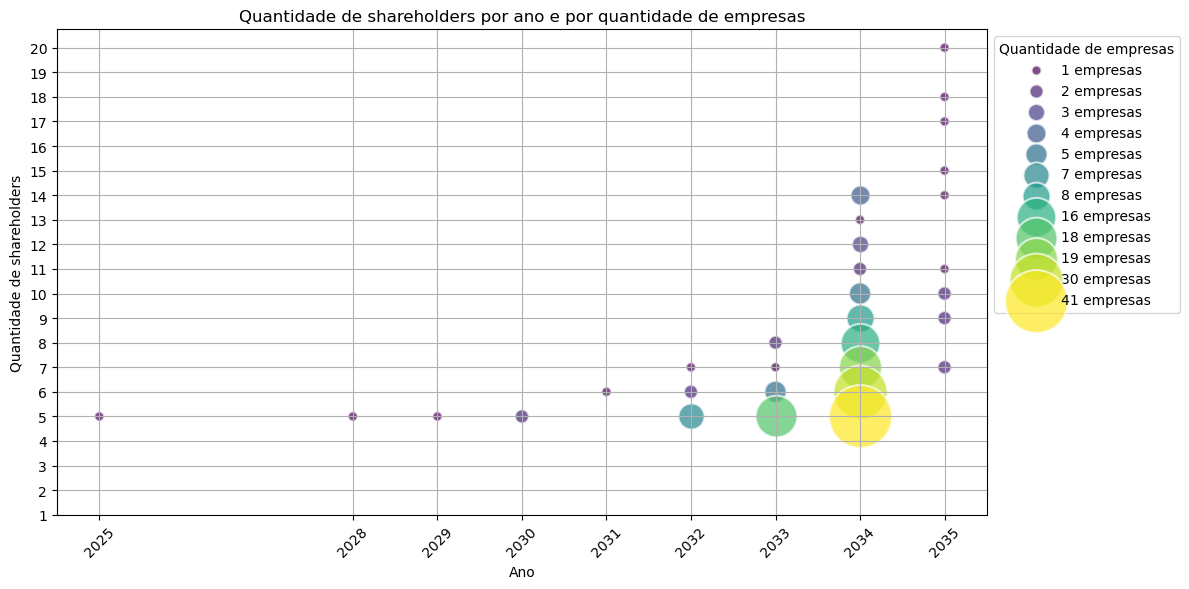

In [217]:
num_companies_unique = sorted(df['num_companies'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(num_companies_unique)))

# Mapeando as cores para cada valor único de num_companies
color_map = {num_companies: colors[i] for i, num_companies in enumerate(num_companies_unique)}

# Convertendo num_companies para cores correspondentes
df['color'] = df['num_companies'].map(color_map)

# Preparando o gráfico de dispersão
plt.figure(figsize=(12, 6))
for num_companies in num_companies_unique:
    df_filtered = df[df['num_companies'] == num_companies]
    plt.scatter(df_filtered['start_date'], df_filtered['count_shareholdership_adquirentes'], s=df_filtered['num_companies']*50, c=[color_map[num_companies]], label=f'{num_companies} empresas', alpha=0.7, edgecolors='w', linewidth=1.5)

# Adicionando título e rótulos dos eixos
plt.title('Quantidade de shareholders por ano e por quantidade de empresas')
plt.xlabel('Ano')
plt.ylabel('Quantidade de shareholders')

# Adicionando a legenda
plt.legend(title='Quantidade de empresas', loc='upper left', bbox_to_anchor=(1, 1))

# Configurando os ticks para mostrar todos os valores
plt.xticks(df['start_date'].unique(), rotation=45)
plt.yticks(np.arange(1, df['count_shareholdership_adquirentes'].max() + 1))

plt.grid(True)
plt.tight_layout()
plt.show()

In [220]:
lista_empresas = count_shareholdership_adquirentes[(count_shareholdership_adquirentes['count'] > media_shareholder)  & (count_shareholdership_adquirentes['start_date'] == 2035)][['target', 'count']]
#lista_empresas
lista_empresas_adq = df_nodos[df_nodos['id'].isin(lista_empresas['target'])][['id', 'type']]
merged_df = lista_empresas_adq.merge(lista_empresas, left_on='id', right_on='target', how='inner')
merged_df = merged_df[['target', 'type', 'count']].sort_values(by='count', ascending=False)
merged_df = merged_df.rename(columns={'count': 'count_shareholdership_adquirentes'})
merged_df

,target,type,count_shareholdership_adquirentes
0,Tomanová Musil s.r.o.,Entity.Organization.Company,20
11,Hájková Burešová a.s.,Entity.Organization.Company,18
6,Němec Janečková s.r.o.,Entity.Organization.Company,17
8,Mareš Jelínková k.s.,Entity.Organization.Company,15
10,Šťastná Strnad v.o.s.,Entity.Organization.Company,14
3,Mašková Marková s.r.o.,Entity.Organization.Company,11
7,Polák Procházka a.s.,Entity.Organization.Company,10
9,Bílek a.s.,Entity.Organization.Company,10
4,Pospíšilová Valentová s.r.o.,Entity.Organization.Company,9
5,Čechová Kašpar s.r.o.,Entity.Organization.Company,9


In [222]:
lista_aquisicoes = df_links_shareholdership[(df_links_shareholdership['target'].isin(lista_empresas['target'])) & (df_links_shareholdership['year'] == 2035)][['source', 'target']]
filtered_nodos = df_nodos[df_nodos['id'].isin(lista_aquisicoes['source'])][['id', 'type']]
merged_df = lista_aquisicoes.merge(filtered_nodos, left_on='source', right_on='id', how='inner')
merged_df = merged_df[['source', 'type', 'target']]
merged_df[merged_df['target'] == 'Tomanová Musil s.r.o.']
#merged_df

,source,type,target
0,"Gallegos, Brooks and Miller",Entity.Organization.Company,Tomanová Musil s.r.o.
21,Crystal Jarvis MD,Entity.Person,Tomanová Musil s.r.o.
30,Susan Marques,Entity.Person,Tomanová Musil s.r.o.
31,Brett Lloyd,Entity.Person,Tomanová Musil s.r.o.
32,Corey Cohen,Entity.Person,Tomanová Musil s.r.o.
33,Daniel Rocha,Entity.Person,Tomanová Musil s.r.o.
34,Ebony Humphrey,Entity.Person,Tomanová Musil s.r.o.
35,Devin Morgan,Entity.Person,Tomanová Musil s.r.o.
36,Diana Bell,Entity.Person,Tomanová Musil s.r.o.
37,Darlene White,Entity.Person,Tomanová Musil s.r.o.


## Empresas adquiridas


In [223]:
max_shareholder_year_adquiridas = count_shareholdership_adquiridas.groupby('start_date')['count'].max().reset_index()

In [224]:
max_shareholder_year_adquiridas

,start_date,count
0,2001,1
1,2002,1
2,2003,1
3,2004,1
4,2005,2
5,2006,1
6,2007,1
7,2008,1
8,2009,2
9,2010,2


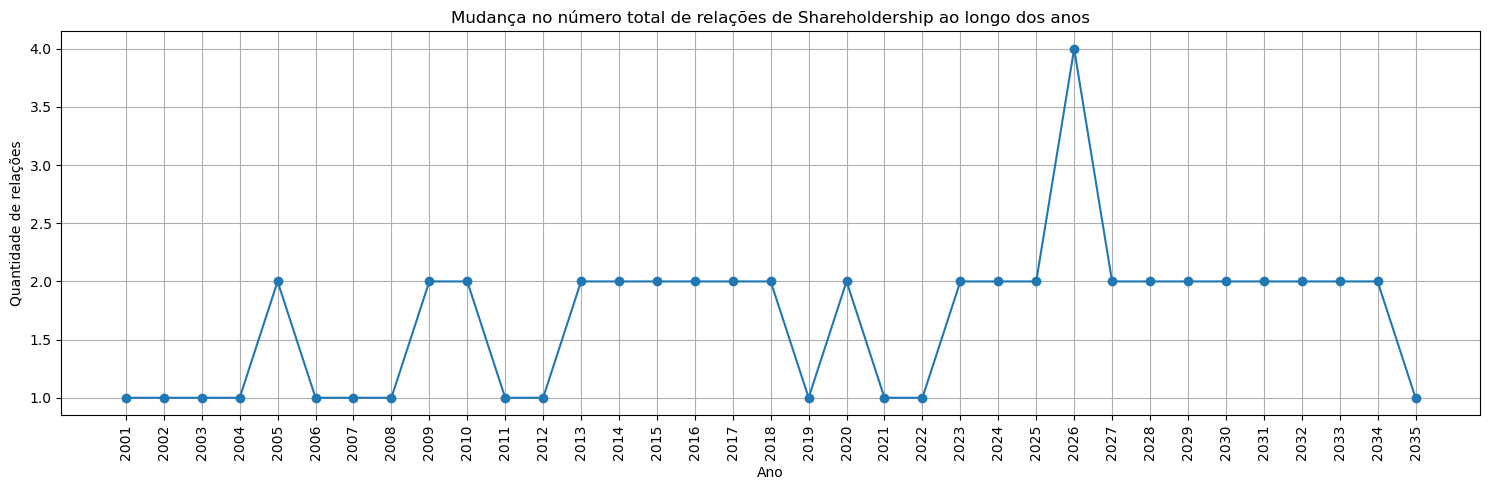

In [225]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_shareholder_year_adquiridas['start_date'], max_shareholder_year_adquiridas['count'], marker='o')
plt.title('Mudança no número total de relações de Shareholdership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_shareholder_year_adquiridas['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [226]:
df = count_shareholdership_adquiridas[count_shareholdership_adquiridas['count'] > 1].groupby(['count', 'start_date']).size().reset_index(name='num_companies').sort_values(by='start_date')

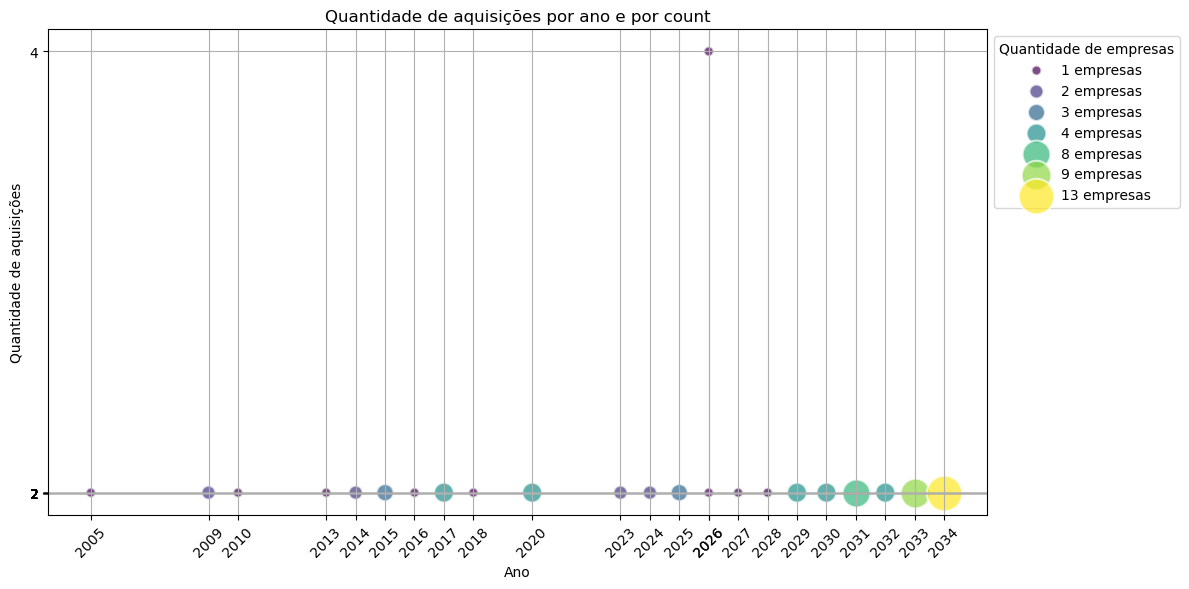

In [227]:

# Determinando as cores com base na quantidade de empresas (num_companies)
num_companies_unique = sorted(df['num_companies'].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(num_companies_unique)))

# Mapeando as cores para cada valor único de num_companies
color_map = {num_companies: colors[i] for i, num_companies in enumerate(num_companies_unique)}

# Convertendo num_companies para cores correspondentes
df['color'] = df['num_companies'].map(color_map)

# Preparando o gráfico de dispersão
plt.figure(figsize=(12, 6))
for i, num_companies in enumerate(num_companies_unique):
    df_filtered = df[df['num_companies'] == num_companies]
    plt.scatter(df_filtered['start_date'], df_filtered['count'], s=df_filtered['num_companies']*50, c=[color_map[num_companies]], label=f'{num_companies} empresas', alpha=0.7, edgecolors='w', linewidth=1.5)

# Adicionando título e rótulos dos eixos
plt.title('Quantidade de aquisições por ano e por count')
plt.xlabel('Ano')
plt.ylabel('Quantidade de aquisições')

# Adicionando a legenda
plt.legend(title='Quantidade de empresas', loc='upper left', bbox_to_anchor=(1, 1))

# Configurando os ticks para mostrar todos os valores
plt.xticks(df['start_date'], rotation=45)
plt.yticks(df['count'])

plt.grid(True)
plt.tight_layout()
plt.show()

In [228]:
lista_proprietarios = count_shareholdership_adquiridas[(count_shareholdership_adquiridas['count'] > 1)  & (count_shareholdership_adquiridas['start_date'] == 2034)]['source']
df_nodos[df_nodos['id'].isin(lista_proprietarios)][['id', 'type']]

,id,type
3028,Hamilton-Park,Entity.Organization.Company
23506,Xavier Guillaume,Entity.Person.CEO
26452,David Copeland,Entity.Person
30923,Paige Palmer,Entity.Person
30957,Peter Hunter,Entity.Person
33345,Phillip Rogers,Entity.Person
35279,Amber Gonzales,Entity.Person
36863,Dr. Kimberly Camacho,Entity.Person
38648,Gwendolyn Phillips,Entity.Person
39687,Luke Hampton,Entity.Person


In [229]:
lista_aquisicoes = df_links_shareholdership[(df_links_shareholdership['source'].isin(lista_proprietarios)) & (df_links_shareholdership['year'] == 2034)][['source', 'target']]
filtered_nodos = df_nodos[df_nodos['id'].isin(lista_aquisicoes['target'])][['id', 'type']]
merged_df = lista_aquisicoes.merge(filtered_nodos, left_on='target', right_on='id', how='inner')
merged_df = merged_df[['source', 'target', 'type']]
merged_df

,source,target,type
0,Hamilton-Park,Carlson-Wang,Entity.Organization.Company
1,Hamilton-Park,Johnson-Gonzalez,Entity.Organization.Company
2,Xavier Guillaume,Harding LLC,Entity.Organization.Company
3,Xavier Guillaume,Morse Group,Entity.Organization.Company
4,David Copeland,"Barrett, Morales and Gonzalez",Entity.Organization.Company
5,David Copeland,Cortez LLC,Entity.Organization.Company
6,Paige Palmer,Cook-Terry,Entity.Organization.Company
7,Paige Palmer,Wade-Lynn,Entity.Organization.FishingCompany
8,Peter Hunter,Cooper Inc,Entity.Organization.Company
9,Peter Hunter,"Patrick, Mcneil and Williams",Entity.Organization.Company


In [230]:
count_shareholdership_adquiridas[(count_shareholdership_adquiridas['count'] == 4)]['source']

30593    Raymond LLC
Name: source, dtype: object

In [231]:
#df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC')  & (df_links_shareholdership['year'] == 2026)]['target']

filtered_links = df_links_shareholdership[(df_links_shareholdership['source'] == 'Raymond LLC') & (df_links_shareholdership['year'] == 2026)]['target']

# Filtrando df_nodos usando os nós filtrados
filtered_nodos = df_nodos[df_nodos['id'].isin(filtered_links)]

# Mesclando os DataFrames para incluir 'source' antes de 'id'
merged_df = df_links_shareholdership.merge(filtered_nodos, left_on='target', right_on='id', how='inner')

# Reordenando as colunas para ter 'source' antes de 'id'
merged_df = merged_df[['source', 'id', 'type_y']]
merged_df

,source,id,type_y
0,Raymond LLC,May and Sons,Entity.Organization.Company
1,Raymond LLC,Jacobs PLC,Entity.Organization.Company
2,Raymond LLC,Conrad Ltd,Entity.Organization.FishingCompany
3,Raymond LLC,Vargas Ltd,Entity.Organization.Company


In [ ]:
G = nx.node_link_graph(data)

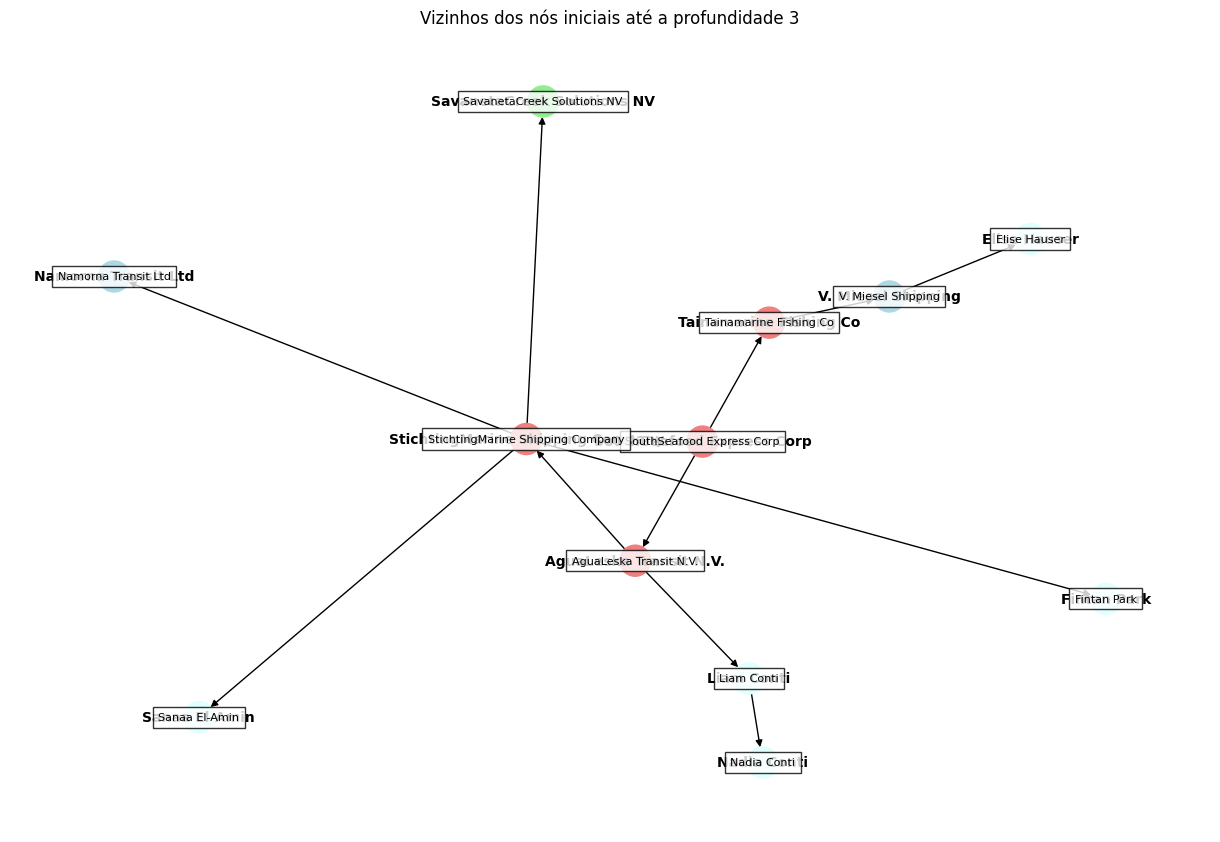

In [ ]:

# Set the initial nodes
initial_nodes = [
"Joel Richards",
"Jessica Gentry",
"Carrie Hester",
"Kaylee Marshall",
"Linda Murray",
"Dawn Sanders",
"Shawn Perkins",
"Heidi Peters",
"Lawrence Lopez",
"Tyler Le"
]
initial_nodes = ["SouthSeafood Express Corp"]

depth = 3  # Define a profundidade desejada

# Create a subgraph by iteratively adding neighbors
subgraph = nx.DiGraph()

# Adicionando os nós iniciais ao subgrafo
for node in initial_nodes:
    node_type = next((n['type'] for n in data['nodes'] if n['id'] == node), None)
    subgraph.add_node(node, type=node_type)

# Explorando vizinhos até a profundidade especificada
nodes_to_explore = [(node, 0) for node in initial_nodes]

while nodes_to_explore:
    node, node_depth = nodes_to_explore.pop(0)  # Obter o próximo nó para explorar
    if node_depth < depth:
        neighbors = list(G.neighbors(node)) + list(G.predecessors(node))  # Obter vizinhos e predecessores
        for neighbor in neighbors:
            if neighbor not in subgraph.nodes:
                node_type = next((n['type'] for n in data['nodes'] if n['id'] == neighbor), None)
                subgraph.add_node(neighbor, type=node_type)  # Adicionar nó com seu tipo
                subgraph.add_edge(node, neighbor)
                nodes_to_explore.append((neighbor, node_depth + 1))

# Mapeamento de cores com base no tipo de nó
color_mapping = {
    'Entity.Organization.Company': 'lightblue',
    'Entity.Organization.LogisticsCompany': 'lightgreen',
    'Entity.Organization.FishingCompany': 'lightcoral',
    'Entity.Organization.FinancialCompany': 'lightyellow',
    'Entity.Organization.NewsCompany': 'lightpink',
    'Entity.Organization.NGO': 'lightgrey',
    'Entity.Person': 'lightcyan',
    'Entity.Person.CEO': 'lightorange'
}

# Desenhar o subgrafo com cores de nós com base no tipo
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph)  # Layout para os nós
node_colors = [color_mapping[subgraph.nodes[node]['type']] for node in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_weight='bold')

# Adicionar tooltips para cada nó
tooltips = {node: f"{node}: {next((n for n in data['nodes'] if n['id'] == node), None)}" for node in subgraph.nodes}

# Adicionar tooltips
for node, (x, y) in pos.items():
    plt.text(x, y, node, bbox=dict(facecolor='white', alpha=0.8), fontsize=8, ha='center', va='center')

plt.title(f"Vizinhos dos nós iniciais até a profundidade {depth}")
plt.show()

In [232]:
G = nx.node_link_graph(data)

# Lista de nós para verificar conexão com "SouthSeafood Express Corp"
nodes_to_check = [
"Joel Richards",
"Jessica Gentry",
"Carrie Hester",
"Kaylee Marshall",
"Linda Murray",
"Dawn Sanders",
"Shawn Perkins",
"Heidi Peters",
"Lawrence Lopez",
"Tyler Le"
]

# Verificar conexão com "SouthSeafood Express Corp"
for node in nodes_to_check:
    if nx.has_path(G, node, "SouthSeafood Express Corp"):
        print(f"{node} está conectado com SouthSeafood Express Corp.")

## Beneficiarios

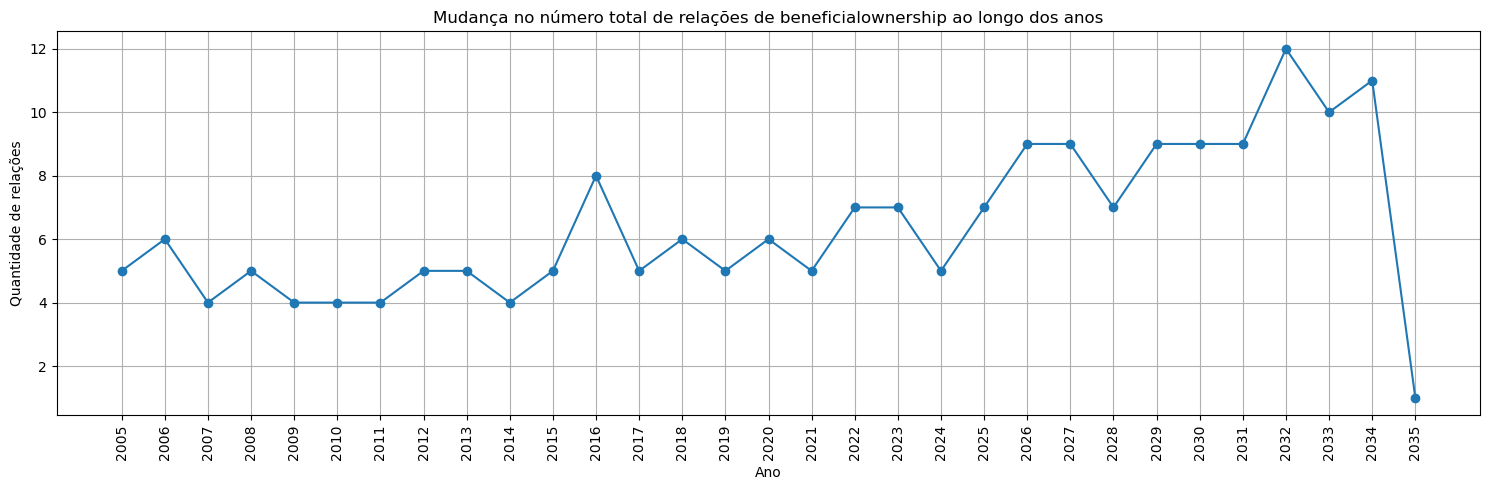

In [233]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_beneficialownership_year['start_date'], max_beneficialownership_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_beneficialownership_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

##  Number Works

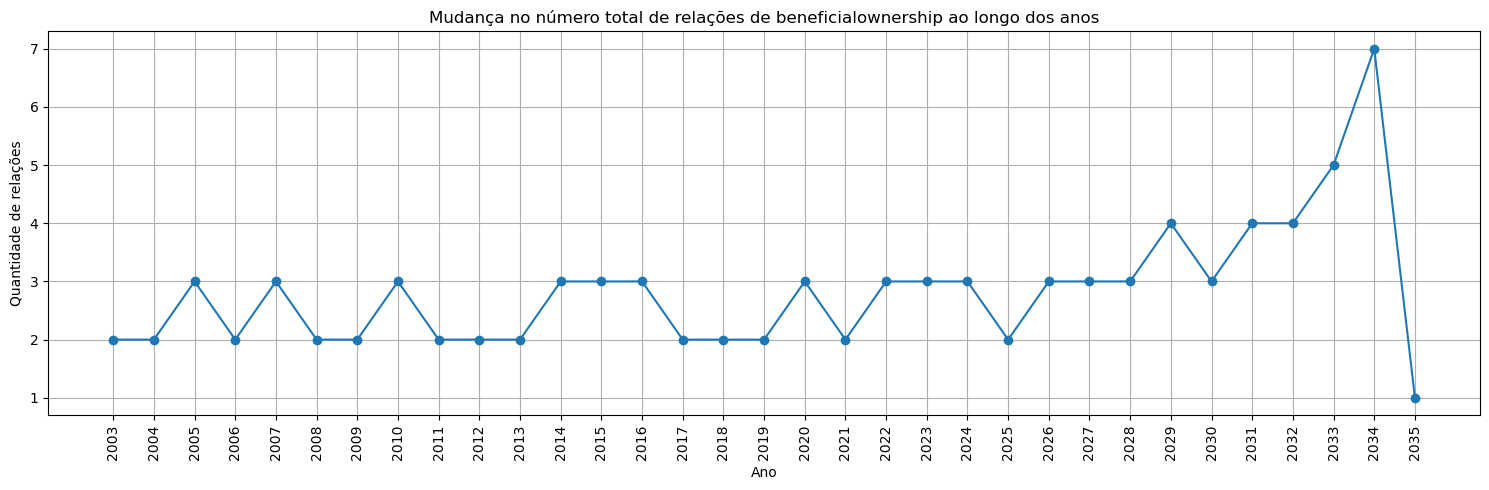

In [235]:
# Plotar o gráfico de linhas
plt.figure(figsize=(15, 5))
plt.plot(max_count_worksfor_year['start_date'], max_count_worksfor_year['count'], marker='o')
plt.title('Mudança no número total de relações de beneficialownership ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('Quantidade de relações')
plt.xticks(rotation=90)
plt.xticks(max_count_worksfor_year['start_date'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [236]:
plt.figure(figsize=(12, 6))
plt.plot(years, familyrelationship_counts, marker='o', linestyle='-', color='purple', label='Family Relationship')
plt.title('Quantidade de Family Relationship ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Número de Relações')
plt.xticks(years)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'years' is not defined

<Figure size 1200x600 with 0 Axes>

* Event.Owns.Shareholdership (Propriedade/Acionistas):

Esta relação indica que uma entidade (por exemplo, uma empresa) possui participação acionária em outra entidade. É útil para entender a estrutura de propriedade e as conexões acionárias entre empresas.

* Event.Owns.BeneficialOwnership (Propriedade Beneficiária):

Este tipo de relação se refere à propriedade beneficiária, que é diferente da propriedade legal direta. Indica que uma entidade possui benefício econômico de uma propriedade, mesmo que não seja o proprietário legal registrado. É comumente usado para identificar quem realmente se beneficia das ações ou propriedades de uma empresa, especialmente em estruturas complexas de propriedade.

* Event.WorksFor (Trabalha Para):

Esta relação indica que uma pessoa ou entidade trabalha para outra. Por exemplo, um funcionário trabalha para uma empresa. É útil para entender a estrutura organizacional e as relações de emprego dentro das entidades.

* Relationship.FamilyRelationship (Relacionamento Familiar):

Este tipo de relação indica um relacionamento familiar entre entidades. Pode ser usado para identificar conexões familiares dentro de empresas ou entre entidades, o que pode influenciar decisões empresariais e estratégias.